(ttest)=
# Comparing Two Means

(onesamplettest)=
## The one-sample $z$-test

In this section I'll describe one of the most useless tests in all of statistics: the **_$z$-test_**. Seriously -- this test is almost never used in real life. Its only real purpose is that, when teaching statistics, it's a very convenient stepping stone along the way towards the $t$-test, which is probably the most (over)used tool in all statistics.

### The inference problem that the test addresses

To introduce the idea behind the $z$-test, let's use a simple example. A friend of mine, Dr Zeppo, grades his introductory statistics class on a curve. Let's suppose that the average grade in his class is 67.5, and the standard deviation is 9.5. Of his many hundreds of students, it turns out that 20 of them also take psychology classes. Out of curiosity, I find myself wondering: do the psychology students tend to get the same grades as everyone else (i.e., mean 67.5) or do they tend to score higher or lower? He emails me the `zeppo.csv` file, which I use to pull up the `grades` of those students, 

In [7]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/ethanweed/pythonbook/main/Data/zeppo.csv")
df.head()

,grades
0,50
1,60
2,60
3,64
4,66


and calculate the mean:

In [8]:
df['grades'].mean()

np.float64(72.3)

### Constructing the hypothesis test

The first step in constructing a hypothesis test is to be clear about what the null and alternative hypotheses are. This isn't too hard to do. Our null hypothesis, $H_0$, is that the true population mean $\mu$ for psychology student grades is 67.5\%; and our alternative hypothesis is that the population mean is bigger than 67.5\%. 




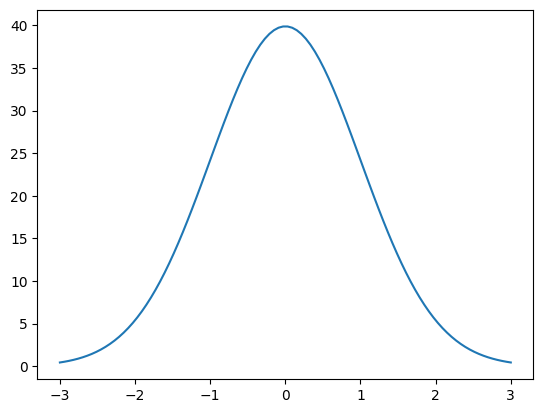

In [9]:
# An example of normal distribution - not necessary for z test 

import numpy as np
import seaborn as sns
from scipy import stats
from matplotlib import pyplot as plt

mu = 0
sigma = 1
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y = 100* stats.norm.pdf(x, mu, sigma)

plt.plot(x, y)
plt.show()


### A worked example using Python

Now, as I mentioned earlier, the $z$-test is almost never used in practice. However, the test is so incredibly simple that it's really easy to do one manually. Let's go back to the data from Dr Zeppo's class. Having loaded the `grades` data, the first thing I need to do is calculate the sample mean:

In [10]:
from statsmodels.stats import weightstats as stests

# Conduct the z-test
z_stat, p_value = stests.ztest(df['grades'], value=67.5, alternative='larger')

# Print the z-statistic and p-value
print(f'Z-statistic: {z_stat}')
print(f'P-value: {p_value}')

Z-statistic: 2.25471286700693
P-value: 0.012075678745258273


In [12]:
# An example of a two-sided test

# Conduct the t-test
t_stat, p_value = stats.ttest_1samp(df['grades'], 67.5)

# Print the t-statistic and p-value
print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')
    

T-statistic: 2.25471286700693
P-value: 0.03614521878144544


If you predetermine the confidence level being 95% (alpha = 0.05), you will reject the null hypothesis. However, if your confidence level requires to be 99%, you cannot reject the null hypothesis. 

### Doing the test in Python


`scipy.stats` includes a variety of methods for running different kinds of  $t$-tests, but the `pingouin` package makes wraps these up and makes them easier (to my mind) to deal with. We'll start with the `scipy` version for the one-sample $t$-test, so you can get a flavor for how `scipy` deals with $t$-tests, and then use the `pingouin` alternatives for the rest.

To run a one-sample $t$-test with `scipy`, use the `ttest_1samp` method. It's pretty straightforward to use: all you need to do is specify `a`, the variable containing the data, and `popmean`, the true population mean according to the null hypothesis. All you need to type is this:

In [ ]:
from scipy.stats import ttest_1samp
t, p = ttest_1samp(a = df['grades'], popmean = 67.5)
t, p



> With a mean grade of 72.3, the psychology students scored slightly higher than the average grade of 67.5 ($t(19) = 2.25$, $p<.05$); the 95\% confidence interval is [67.8, 76.8].

But the `ttest-lsamp` does not provide us the confidence interval. We need to calculate seperately. Hence, it seems more convenient to use `pingouin` command.

Having gone through all that, let's take a look at the `pingouin` command to achieve the same thing.

In [ ]:
# if you haven't installed pingouin yet, you can do so by uncommenting the line below
# !pip install pingouin

In [13]:

from pingouin import ttest
ttest(df['grades'], 67.5).round(2)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.25,19,two-sided,0.04,"[67.84, 76.76]",0.5,1.795,0.57


Well. That was easy! All we need to do is feed the `ttest()` function from `pingouin` with the data and the population mean under the null hypothesis, and `pinguoin` does the rest. We get a nice table with the $t$-value, the degrees of freedom, the $p$-value, 95% confidence interval, effect size (Cohen's $d$), and a power estimate. BF10 refers to the "bayes factor", which we will meet (briefly) in the section on [Bayesian statistics](bayes).

(studentttest)=
## The independent two samples $t$-test (Student test)



### The data

Suppose we have 33 students taking Dr Harpo's statistics lectures, and Dr Harpo doesn't grade to a curve. Actually, Dr Harpo's grading is a bit of a mystery, so we don't really know anything about what the average grade is for the class as a whole. There are two tutors for the class, Anastasia and Bernadette. There are $N_1 = 15$ students in Anastasia's tutorials, and $N_2 = 18$ in Bernadette's tutorials. The research question I'm interested in is whether Anastasia or Bernadette is a better tutor, or if it doesn't make much of a difference. Dr Harpo emails me the course grades, in the `harpo.csv` file. As usual, I'll load the file and have a look at what variables it contains:

In [15]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/ethanweed/pythonbook/main/Data/harpo.csv")
df.head()

,grade,tutor
0,65,Anastasia
1,72,Bernadette
2,66,Bernadette
3,74,Anastasia
4,73,Anastasia


As we can see, there's a single data frame with two variables, `grade` and `tutor`. The `grade` variable is a numeric vector, containing the grades for all $N = 33$ students taking Dr Harpo's class; the `tutor` variable is a factor that indicates who each student's tutor was. The first five observations in this data set are shown above, and below is a nice little table with some summary statistics:

In [16]:
harpo_summary = pd.DataFrame(
    {'students': ['Anastasia\'s students','Bernadette\'s students'],
     'mean': [df.loc[df['tutor'] == 'Anastasia']['grade'].mean().round(2), 
             df.loc[df['tutor'] == 'Bernadette']['grade'].mean().round(2)],
     'std dev': [df.loc[df['tutor'] == 'Anastasia']['grade'].std(), 
                df.loc[df['tutor'] == 'Bernadette']['grade'].std()],
     'N': [len(df.loc[df['tutor'] == 'Anastasia']),
           len(df.loc[df['tutor'] == 'Bernadette'])]
    })
harpo_summary

,students,mean,std dev,N
0,Anastasia's students,74.53,8.998942,15
1,Bernadette's students,69.06,5.774918,18


To give you a more detailed sense of what's going on here, I've plotted histograms showing the distribution of grades for both tutors {numref}`fig-harpohist`. Inspection of these histograms suggests that the students in Anastasia's class may be getting slightly better grades on average, though they also seem a little more variable.

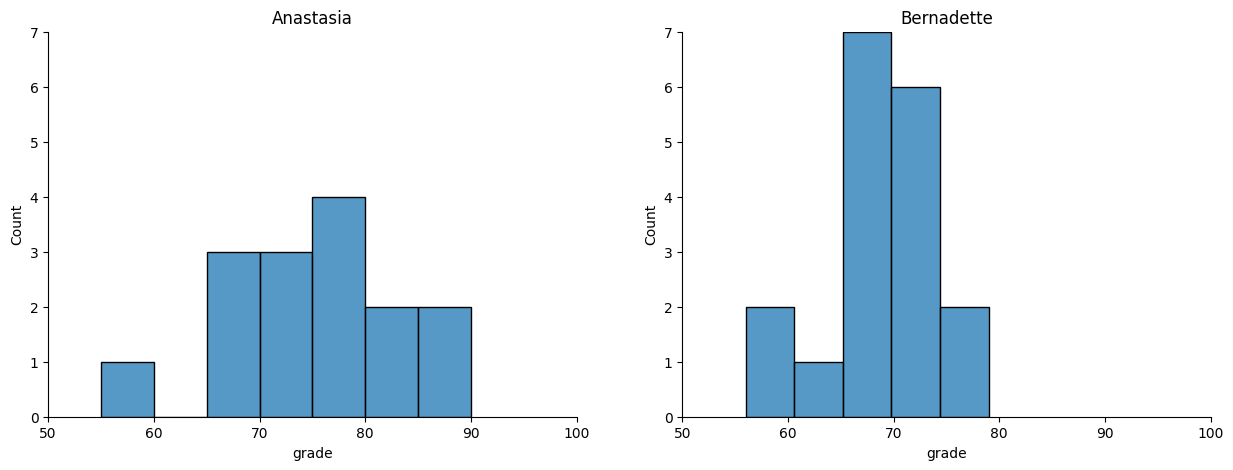

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
Anastasia = pd.DataFrame(df.loc[df['tutor'] == 'Anastasia']['grade'])
Bernadette = pd.DataFrame(df.loc[df['tutor'] == 'Bernadette']['grade'])

sns.histplot(Anastasia['grade'], ax = axes[0], binwidth = 5)
sns.histplot(Bernadette['grade'], ax = axes[1], binwidth = 5)

axes[0].set_xlim(50,100)
axes[1].set_xlim(50,100)

axes[0].set_ylim(0,7)
axes[1].set_ylim(0,7)

axes[0].set_title('Anastasia')
axes[1].set_title('Bernadette')

sns.despine()

# show the figure in the book with caption
plt.show()

### Introducing the test

$$
\begin{array}{ll}
H_0: & \mu_1 = \mu_2  \\
H_1: & \mu_1 \neq \mu_2
\end{array}
$$

### Doing the test in Python



In [21]:

Harpo_wide = pd.DataFrame(
                {'Anastasia': df.loc[df['tutor'] == 'Anastasia']['grade'],
                 'Bernadette': df.loc[df['tutor'] == 'Bernadette']['grade']})

Harpo_wide.head()


,Anastasia,Bernadette
0,65.0,NaN
1,NaN,72.0
2,NaN,66.0
3,74.0,NaN
4,73.0,NaN


Now, you will have noticed right away that this new dataframe has a bunch of things that aren't numbers in it. In fact, "NaN" stands for "Not a Number". But after a moment's reflection, this makes perfect sense: the students were divided up between Anastasia and Bernadette, and so of course now that we have a row for each student, if a student has Anastasia as a tutor, they can't _also_ have Bernadette as a tutor. Luckily, `ttest()` is smart enough to see what is going on, and deal with it appropriately. So, now that we have all of our ducks in order, let's do the test:

In [22]:
from pingouin import ttest

ttest(Harpo_wide['Anastasia'], Harpo_wide['Bernadette'], correction = False)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.115432,31,two-sided,0.042529,"[0.2, 10.76]",0.739561,1.755,0.53577


You probably noticed that in addition to telling `ttest()` which means I wanted to compare, I also added the argument `correction = False` to the command. This wasn't strictly necessary in this case, because by default this argument is set to `True`. By saying `correction = False`, what we're really doing is telling Python to use the *Student* independent samples $t$-test, and not the *Welch* independent samples $t$-test. More on this later, when we get to [Welch](welchttest). For now, let's just get the descriptive statistics for Anastasia and Bernadette's students so we can report our results:

In [23]:

Harpo_wide.describe()

,Anastasia,Bernadette
count,15.000000,18.000000
mean,74.533333,69.055556
std,8.998942,5.774918
min,55.000000,56.000000
25%,69.000000,66.250000
50%,76.000000,69.000000
75%,79.000000,73.000000
max,90.000000,79.000000


The difference between the two groups is significant (just barely), so we might write up the result using text like this:

> The mean grade in Anastasia's class was 74.5\% (std dev = 9.0), whereas the mean in Bernadette's class was 69.1\% (std dev = 5.8). A Student's independent samples $t$-test showed that this 5.4\% difference was significant ($t(31) = 2.1$, $p<.05$), suggesting that a genuine difference in learning outcomes has occurred.
